In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
#from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle

%matplotlib inline 

In [2]:
def GetCoordPSR(name):
    # Get the PSR coordinates from SIMBAD database
    return SkyCoord(ra=Simbad.query_object(name)['RA'][0], dec=Simbad.query_object(name)['DEC'][0], unit=(u.hourangle, u.deg))

def AngSeparation(reference,obj):
    # Calculates the angular separation between reference position and obj
    return reference.separation(obj)

def ScaledCtRate(D,OptCtRate,effareaX,effareaY):
    # Scale a given count rate (OptCtRate) given an angular distance D
    # EffAreaX corresponds to Effective Area
    # EffAreaY corresponds to OffAxisAngle
    return OptCtRate * np.interp(D,effareaX,effareaY)

def SignaltoNoise(SrcCtsRate,BkgSrcRates,InstBkgd,ExpTime):
    # Calculate the S/N rate given
    #  1) Source count rate
    #  2) Sum the count rates due to background sources.
    #  3) the exposure time (ExpTime)
    #  4) the instrumental+particule background
    SNR = (SrcCtsRate*ExpTime) / np.sqrt(ExpTime*(SrcCtsRate+np.sum(BkgSrcRates)+InstBkgd))
    return SNR

In [3]:
## load vigneting information:
## Effective area (EffArea) as function of OffAxisAngle
EffArea,OffAxisAngle = np.loadtxt("NICER_PSF.dat",unpack=True,usecols=(0,1))

In [4]:
## Makes a Pulsar table.
PSRfullnames   = ['PSR J0437-4715','PSR J2124-3358','PSR J0751+1807']
PSRshortnames  = ['PSR0437','PSR2124','PSR0751']
PSRcountrates  = [1.319,0.1,0.025]
PSRtable = Table([PSRfullnames, PSRshortnames, PSRcountrates], 
                 names=('FullName', 'ShortName', 'Count Rate'))

PSR S/N at Nominal Pointing 45.3305577953
PSR count rate at Nominal pointing = 0.025 cts/sec
BKG sources count rate at Nominal pointing = 0.0791570526432 cts/sec
     Individual BKG Sources rates: 
[  5.40137423e-02   2.25693314e-02   2.03994773e-03   2.61737493e-04
   7.33294240e-05   4.20828205e-05   2.44571289e-05   6.58992892e-05
   5.91129211e-05   7.41211662e-06]
    BKG sources distance from PSR (')
[ 2.4212975   1.61095765  4.02946756  4.70792703  6.67964411  7.02483258
  6.90079081  5.1791227   5.23831356  8.38410961]
----------------------------------------------------------------------
PSR S/N at Optimal Pointing 46.9411197662
PSR count rate at Optimal pointing = 0.024344774261 cts/sec
BKG sources count rate at Optimal pointing = 0.0446257026613 cts/sec
     Individual BKG Sources: 
[  1.62515931e-02   2.04469776e-02   5.70527361e-03   1.72803257e-03
   3.32967888e-05   6.41383737e-05   3.30095352e-06   2.19299201e-05
   3.65305817e-04   5.85393243e-06]
Optimal Pointing:  11

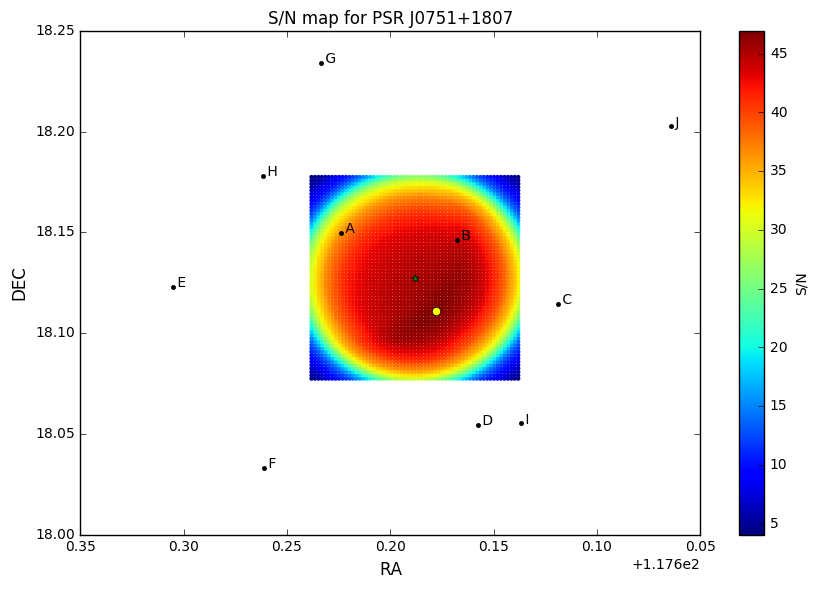

In [5]:
# Set pulsar
Pulsar = 'PSR J0751+1807'

# Load info about nearby sources. Format: ra(deg), dec(deg), countrate(c/s)
src_filename = "NearbySources_"+ PSRtable['ShortName'][PSRtable['FullName'] == Pulsar][0]+".reg"
NearbySources = np.loadtxt(src_filename,unpack=True,usecols=(0,1,2))
SRCposition  = SkyCoord(ra=NearbySources[0]*u.degree, dec=NearbySources[1]*u.degree)

# Get pulsar info
PSRposition  = GetCoordPSR(Pulsar)
PSRcountrate = PSRtable['Count Rate'][PSRtable['FullName'] == Pulsar][0]

# Set other parameters
INSTbkgd=0.2
EXPtime=1000000

# Print info for Nominal pointing of NICER on the target PSR
SRCnominalDIST = AngSeparation(SRCposition,SkyCoord(ra=PSRposition.ra, dec=PSRposition.dec)).arcmin
SRCscaleRates = ScaledCtRate(SRCnominalDIST,NearbySources[2],EffArea,OffAxisAngle)
print "PSR S/N at Nominal Pointing " + str(SignaltoNoise(PSRcountrate,SRCscaleRates,INSTbkgd,EXPtime))
print "PSR count rate at Nominal pointing = " + str(PSRcountrate) + " cts/sec"
print "BKG sources count rate at Nominal pointing = " + str(np.sum(SRCscaleRates)) + " cts/sec"
print "     Individual BKG Sources rates: " 
print str(SRCscaleRates)
print "    BKG sources distance from PSR (\')"
print SRCnominalDIST 
print "----------------------------------------------------------------------"

# Sampling positions:  (-3,3) arcmin in RA, (-3,3) arcmin in DEC,
DeltaRA  = Angle(np.arange(-3, 3.1,0.1), unit=u.deg)/60
DeltaDEC = Angle(np.arange(-3, 3.1,0.1), unit=u.deg)/60
# Other arrays needed
sampleRA = np.zeros(len(DeltaRA)*len(DeltaDEC))
sampleDEC = np.zeros(len(DeltaRA)*len(DeltaDEC))
snr = np.zeros(len(DeltaRA)*len(DeltaDEC))
PSRrates = np.zeros(len(DeltaRA)*len(DeltaDEC))
SRCrates = np.zeros(len(DeltaRA)*len(DeltaDEC))

count = 0
for i in DeltaRA:
    for j in DeltaDEC:
        # Define NICER pointing given the offset
        NICERpointing = SkyCoord(ra=PSRposition.ra + i , dec=PSRposition.dec + j)
        
        # Separation between PSR and NICER 
        PSRseparation = AngSeparation(PSRposition,NICERpointing)
        
        # Separation between Nearby sources and NICER pointing
        SRCseparation = AngSeparation(SRCposition,NICERpointing) 
        
        # New count rates given the NICER pointing 
        PSRcountrateScaled = ScaledCtRate(PSRseparation.arcmin,PSRcountrate,EffArea,OffAxisAngle)
        SRCcountrateScaled = ScaledCtRate(SRCseparation.arcmin,NearbySources[2],EffArea,OffAxisAngle)
        sampleRA[count] = NICERpointing.ra.deg
        sampleDEC[count] = NICERpointing.dec.deg
        PSRrates[count] = PSRcountrateScaled
        SRCrates[count] = np.sum(SRCcountrateScaled)
        
        # Get S/N ratio given the new count rates for PSR and nearby sources. 
        snr[count] = SignaltoNoise(PSRcountrateScaled,SRCcountrateScaled,INSTbkgd,EXPtime)
        count = count+1

# Find which offset maximizes the S/N ratio        
OptimalPointingIdx = np.where(snr==max(snr))[0][0]
SRCoptimalSEPAR = AngSeparation(SRCposition,SkyCoord(ra=sampleRA[OptimalPointingIdx]*u.degree, dec=sampleDEC[OptimalPointingIdx]*u.degree)).arcmin
SRCoptimalRATES = ScaledCtRate(SRCoptimalSEPAR,NearbySources[2],EffArea,OffAxisAngle)

# Print info for the optimal NICER pointing that maximizes the S/N ratio
print "PSR S/N at Optimal Pointing " + str(snr[OptimalPointingIdx])
print "PSR count rate at Optimal pointing = " + str(PSRrates[OptimalPointingIdx]) + " cts/sec"
print "BKG sources count rate at Optimal pointing = " + str(SRCrates[OptimalPointingIdx]) + " cts/sec"
print "     Individual BKG Sources: " 
print str(SRCoptimalRATES)
#print "     Distance from Optimal Pointing (\")"
#print str(SRCoptimalSEPAR)
print "Optimal Pointing:  " + str(sampleRA[OptimalPointingIdx]) + "  " + str(sampleDEC[OptimalPointingIdx])
print "----------------------------------------------------------------------"

# Plot the map of S/N ratio as function of NICER pointing
fig = plt.figure(figsize=(10,6.5))
ax = fig.add_subplot(111)
plt.gca().invert_xaxis()
plt.plot(SRCposition.ra, SRCposition.dec, marker='.', color='black',linestyle='')    
plt.plot(PSRposition.ra, PSRposition.dec, marker='*', color='green',linestyle='')
plt.plot(sampleRA[OptimalPointingIdx], sampleDEC[OptimalPointingIdx], marker='o', color='yellow', linestyle='')

# label of the nearby sources
n=[' A',' B',' C',' D',' E',' F',' G',' H',' I',' J']
for i, txt in enumerate(n):
    ax.annotate(txt, (NearbySources[0,i],NearbySources[1,i]))

plt.scatter(sampleRA, sampleDEC, c=snr, s=10, edgecolor='')
plt.xlabel('RA', fontsize='large')
plt.ylabel('DEC', fontsize='large')
plt.title("S/N map for " + Pulsar)
cbar = plt.colorbar()
cbar.set_label('S/N')
plt.show()

PSR S/N at Nominal Pointing 862.71736046
PSR count rate at Nominal pointing = 1.319 cts/sec
BKG sources count rate at Nominal pointing = 0.818504826212 cts/sec
     Individual BKG Sources rates: 
[  4.05042235e-03   1.14246265e-02   6.39463944e-03   2.79232351e-03
   2.52465485e-03   7.48211932e-03   1.30660315e-03   1.44349988e-03
   4.04165803e-03   1.36177766e-02   5.49705715e-04   7.62876797e-01]
    BKG sources distance from PSR (')
[ 3.26547205  2.06215878  2.72582771  3.13810218  2.25152332  3.61998981
  3.56470213  2.68599899  2.99281215  2.70381327  3.41574679  4.17873802]
----------------------------------------------------------------------
PSR S/N at Optimal Pointing 1002.90966916
PSR count rate at Optimal pointing = 1.25403017049 cts/sec
BKG sources count rate at Optimal pointing = 0.109449842172 cts/sec
     Individual BKG Sources: 
[ 0.00195153  0.00398176  0.00713543  0.00550405  0.00180829  0.00381979
  0.00321613  0.00185241  0.00069023  0.00203261  0.00069671  0.0767

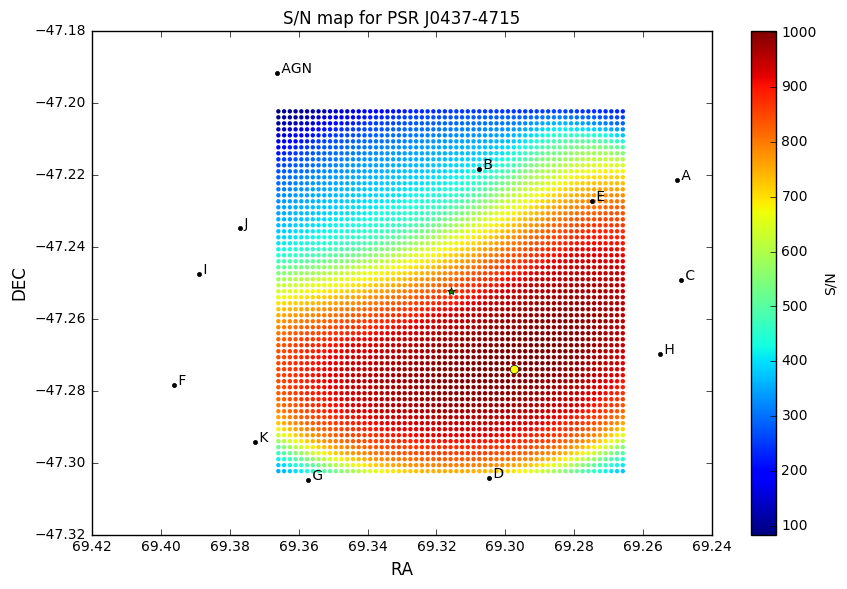

In [6]:
# Set pulsar
Pulsar = 'PSR J0437-4715'

# Load info about nearby sources. Format: ra(deg), dec(deg), countrate(c/s)
src_filename = "NearbySources_"+ PSRtable['ShortName'][PSRtable['FullName'] == Pulsar][0]+".reg"
NearbySources = np.loadtxt(src_filename,unpack=True,usecols=(0,1,2))
SRCposition  = SkyCoord(ra=NearbySources[0]*u.degree, dec=NearbySources[1]*u.degree)

# Get pulsar info
PSRposition  = GetCoordPSR(Pulsar)
PSRcountrate = PSRtable['Count Rate'][PSRtable['FullName'] == Pulsar][0]

# Set other parameters
INSTbkgd=0.2
EXPtime=1000000

# Print info for Nominal pointing of NICER on the target PSR
SRCnominalDIST = AngSeparation(SRCposition,SkyCoord(ra=PSRposition.ra, dec=PSRposition.dec)).arcmin
SRCscaleRates = ScaledCtRate(SRCnominalDIST,NearbySources[2],EffArea,OffAxisAngle)
print "PSR S/N at Nominal Pointing " + str(SignaltoNoise(PSRcountrate,SRCscaleRates,INSTbkgd,EXPtime))
print "PSR count rate at Nominal pointing = " + str(PSRcountrate) + " cts/sec"
print "BKG sources count rate at Nominal pointing = " + str(np.sum(SRCscaleRates)) + " cts/sec"
print "     Individual BKG Sources rates: " 
print str(SRCscaleRates)
print "    BKG sources distance from PSR (\')"
print SRCnominalDIST 
print "----------------------------------------------------------------------"

# Sampling positions:  (-3,3) arcmin in RA, (-3,3) arcmin in DEC,
DeltaRA  = Angle(np.arange(-3, 3.1,0.1), unit=u.deg)/60
DeltaDEC = Angle(np.arange(-3, 3.1,0.1), unit=u.deg)/60
# Other arrays needed
sampleRA = np.zeros(len(DeltaRA)*len(DeltaDEC))
sampleDEC = np.zeros(len(DeltaRA)*len(DeltaDEC))
snr = np.zeros(len(DeltaRA)*len(DeltaDEC))
PSRrates = np.zeros(len(DeltaRA)*len(DeltaDEC))
SRCrates = np.zeros(len(DeltaRA)*len(DeltaDEC))

count = 0
for i in DeltaRA:
    for j in DeltaDEC:
        # Define NICER pointing given the offset
        NICERpointing = SkyCoord(ra=PSRposition.ra + i , dec=PSRposition.dec + j)
        
        # Separation between PSR and NICER 
        PSRseparation = AngSeparation(PSRposition,NICERpointing)
        
        # Separation between Nearby sources and NICER pointing
        SRCseparation = AngSeparation(SRCposition,NICERpointing) 
        
        # New count rates given the NICER pointing 
        PSRcountrateScaled = ScaledCtRate(PSRseparation.arcmin,PSRcountrate,EffArea,OffAxisAngle)
        SRCcountrateScaled = ScaledCtRate(SRCseparation.arcmin,NearbySources[2],EffArea,OffAxisAngle)
        sampleRA[count] = NICERpointing.ra.deg
        sampleDEC[count] = NICERpointing.dec.deg
        PSRrates[count] = PSRcountrateScaled
        SRCrates[count] = np.sum(SRCcountrateScaled)
        
        # Get S/N ratio given the new count rates for PSR and nearby sources. 
        snr[count] = SignaltoNoise(PSRcountrateScaled,SRCcountrateScaled,INSTbkgd,EXPtime)
        count = count+1

# Find which offset maximizes the S/N ratio        
OptimalPointingIdx = np.where(snr==max(snr))[0][0]
SRCoptimalSEPAR = AngSeparation(SRCposition,SkyCoord(ra=sampleRA[OptimalPointingIdx]*u.degree, dec=sampleDEC[OptimalPointingIdx]*u.degree)).arcmin
SRCoptimalRATES = ScaledCtRate(SRCoptimalSEPAR,NearbySources[2],EffArea,OffAxisAngle)

# Print info for the optimal NICER pointing that maximizes the S/N ratio
print "PSR S/N at Optimal Pointing " + str(snr[OptimalPointingIdx])
print "PSR count rate at Optimal pointing = " + str(PSRrates[OptimalPointingIdx]) + " cts/sec"
print "BKG sources count rate at Optimal pointing = " + str(SRCrates[OptimalPointingIdx]) + " cts/sec"
print "     Individual BKG Sources: " 
print str(SRCoptimalRATES)
#print "     Distance from Optimal Pointing (\")"
#print str(SRCoptimalSEPAR)
print "Optimal Pointing:  " + str(sampleRA[OptimalPointingIdx]) + "  " + str(sampleDEC[OptimalPointingIdx])
print "----------------------------------------------------------------------"

# Plot the map of S/N ratio as function of NICER pointing
fig = plt.figure(figsize=(10,6.5))
ax = fig.add_subplot(111)
plt.gca().invert_xaxis()
plt.plot(SRCposition.ra, SRCposition.dec, marker='.', color='black',linestyle='')    
plt.plot(PSRposition.ra, PSRposition.dec, marker='*', color='green',linestyle='')
plt.plot(sampleRA[OptimalPointingIdx], sampleDEC[OptimalPointingIdx], marker='o', color='yellow', linestyle='')

# label of the nearby sources
n=[' A',' B',' C',' D',' E',' F',' G',' H',' I',' J',' K',' AGN']
for i, txt in enumerate(n):
    ax.annotate(txt, (NearbySources[0,i],NearbySources[1,i]))

plt.scatter(sampleRA, sampleDEC, c=snr, s=10, edgecolor='')
plt.xlabel('RA', fontsize='large')
plt.ylabel('DEC', fontsize='large')
plt.title("S/N map for " + Pulsar)
cbar = plt.colorbar()
cbar.set_label('S/N')
plt.show()

PSR S/N at Nominal Pointing 173.268406362
PSR count rate at Nominal pointing = 0.1 cts/sec
BKG sources count rate at Nominal pointing = 0.03308972657 cts/sec
     Individual BKG Sources rates: 
[  2.17917539e-03   4.12993671e-03   2.30487183e-02   3.54468101e-04
   1.69070894e-04   4.56884122e-04   3.12315598e-04   9.21413979e-05
   1.56820741e-04   2.19019531e-03]
    BKG sources distance from PSR (')
[ 4.14770404  4.022496    2.75730083  4.71943801  6.1608601   4.30319187
  4.66157266  6.08986584  6.97538781  7.14881498]
----------------------------------------------------------------------
PSR S/N at Optimal Pointing 175.204359651
PSR count rate at Optimal pointing = 0.098985208416 cts/sec
BKG sources count rate at Optimal pointing = 0.0202059011506 cts/sec
     Individual BKG Sources: 
[  1.02676929e-03   3.49081666e-03   9.12333649e-03   9.14075659e-04
   1.18535775e-04   9.24143170e-04   5.28597379e-04   5.18966902e-05
   1.61081434e-04   3.86664860e-03]
Optimal Pointing:  321.18

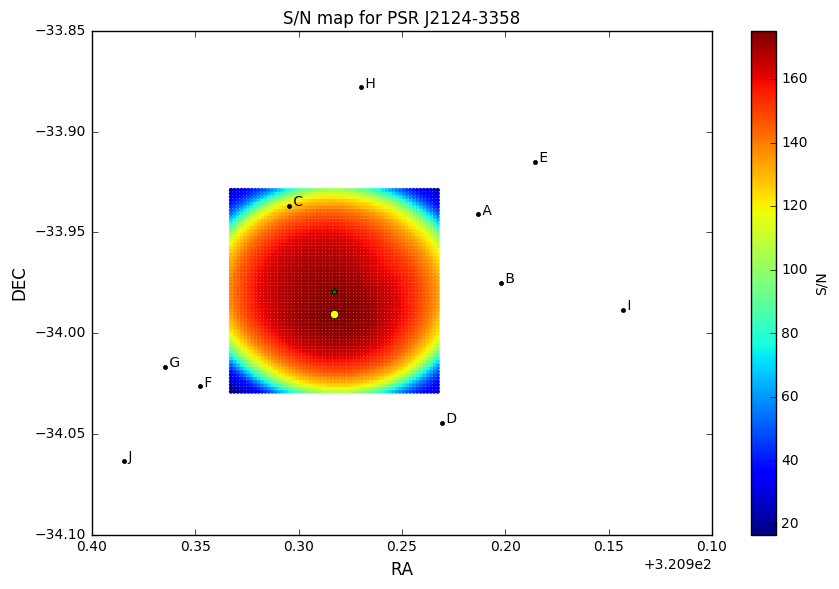

In [7]:
# Set pulsar
Pulsar = 'PSR J2124-3358'

# Load info about nearby sources. Format: ra(deg), dec(deg), countrate(c/s)
src_filename = "NearbySources_"+ PSRtable['ShortName'][PSRtable['FullName'] == Pulsar][0]+".reg"
NearbySources = np.loadtxt(src_filename,unpack=True,usecols=(0,1,2))
SRCposition  = SkyCoord(ra=NearbySources[0]*u.degree, dec=NearbySources[1]*u.degree)

# Get pulsar info
PSRposition  = GetCoordPSR(Pulsar)
PSRcountrate = PSRtable['Count Rate'][PSRtable['FullName'] == Pulsar][0]

# Set other parameters
INSTbkgd=0.2
EXPtime=1000000

# Print info for Nominal pointing of NICER on the target PSR
SRCnominalDIST = AngSeparation(SRCposition,SkyCoord(ra=PSRposition.ra, dec=PSRposition.dec)).arcmin
SRCscaleRates = ScaledCtRate(SRCnominalDIST,NearbySources[2],EffArea,OffAxisAngle)
print "PSR S/N at Nominal Pointing " + str(SignaltoNoise(PSRcountrate,SRCscaleRates,INSTbkgd,EXPtime))
print "PSR count rate at Nominal pointing = " + str(PSRcountrate) + " cts/sec"
print "BKG sources count rate at Nominal pointing = " + str(np.sum(SRCscaleRates)) + " cts/sec"
print "     Individual BKG Sources rates: " 
print str(SRCscaleRates)
print "    BKG sources distance from PSR (\')"
print SRCnominalDIST 
print "----------------------------------------------------------------------"

# Sampling positions:  (-3,3) arcmin in RA, (-3,3) arcmin in DEC,
DeltaRA  = Angle(np.arange(-3, 3.1,0.1), unit=u.deg)/60
DeltaDEC = Angle(np.arange(-3, 3.1,0.1), unit=u.deg)/60
# Other arrays needed
sampleRA = np.zeros(len(DeltaRA)*len(DeltaDEC))
sampleDEC = np.zeros(len(DeltaRA)*len(DeltaDEC))
snr = np.zeros(len(DeltaRA)*len(DeltaDEC))
PSRrates = np.zeros(len(DeltaRA)*len(DeltaDEC))
SRCrates = np.zeros(len(DeltaRA)*len(DeltaDEC))

count = 0
for i in DeltaRA:
    for j in DeltaDEC:
        # Define NICER pointing given the offset
        NICERpointing = SkyCoord(ra=PSRposition.ra + i , dec=PSRposition.dec + j)
        
        # Separation between PSR and NICER 
        PSRseparation = AngSeparation(PSRposition,NICERpointing)
        
        # Separation between Nearby sources and NICER pointing
        SRCseparation = AngSeparation(SRCposition,NICERpointing) 
        
        # New count rates given the NICER pointing 
        PSRcountrateScaled = ScaledCtRate(PSRseparation.arcmin,PSRcountrate,EffArea,OffAxisAngle)
        SRCcountrateScaled = ScaledCtRate(SRCseparation.arcmin,NearbySources[2],EffArea,OffAxisAngle)
        sampleRA[count] = NICERpointing.ra.deg
        sampleDEC[count] = NICERpointing.dec.deg
        PSRrates[count] = PSRcountrateScaled
        SRCrates[count] = np.sum(SRCcountrateScaled)
        
        # Get S/N ratio given the new count rates for PSR and nearby sources. 
        snr[count] = SignaltoNoise(PSRcountrateScaled,SRCcountrateScaled,INSTbkgd,EXPtime)
        count = count+1

# Find which offset maximizes the S/N ratio        
OptimalPointingIdx = np.where(snr==max(snr))[0][0]
SRCoptimalSEPAR = AngSeparation(SRCposition,SkyCoord(ra=sampleRA[OptimalPointingIdx]*u.degree, dec=sampleDEC[OptimalPointingIdx]*u.degree)).arcmin
SRCoptimalRATES = ScaledCtRate(SRCoptimalSEPAR,NearbySources[2],EffArea,OffAxisAngle)

# Print info for the optimal NICER pointing that maximizes the S/N ratio
print "PSR S/N at Optimal Pointing " + str(snr[OptimalPointingIdx])
print "PSR count rate at Optimal pointing = " + str(PSRrates[OptimalPointingIdx]) + " cts/sec"
print "BKG sources count rate at Optimal pointing = " + str(SRCrates[OptimalPointingIdx]) + " cts/sec"
print "     Individual BKG Sources: " 
print str(SRCoptimalRATES)
#print "     Distance from Optimal Pointing (\")"
#print str(SRCoptimalSEPAR)
print "Optimal Pointing:  " + str(sampleRA[OptimalPointingIdx]) + "  " + str(sampleDEC[OptimalPointingIdx])
print "----------------------------------------------------------------------"

# Plot the map of S/N ratio as function of NICER pointing
fig = plt.figure(figsize=(10,6.5))
ax = fig.add_subplot(111)
plt.gca().invert_xaxis()
plt.plot(SRCposition.ra, SRCposition.dec, marker='.', color='black',linestyle='')    
plt.plot(PSRposition.ra, PSRposition.dec, marker='*', color='green',linestyle='')
plt.plot(sampleRA[OptimalPointingIdx], sampleDEC[OptimalPointingIdx], marker='o', color='yellow', linestyle='')

# label of the nearby sources
n=[' A',' B',' C',' D',' E',' F',' G',' H',' I',' J']
for i, txt in enumerate(n):
    ax.annotate(txt, (NearbySources[0,i],NearbySources[1,i]))

plt.scatter(sampleRA, sampleDEC, c=snr, s=10, edgecolor='')
plt.xlabel('RA', fontsize='large')
plt.ylabel('DEC', fontsize='large')
plt.title("S/N map for " + Pulsar)
cbar = plt.colorbar()
cbar.set_label('S/N')
plt.show()